In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import prophet
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
plt.style.use('fivethirtyeight')
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/y_true)) * 100

In [58]:
data = pd.read_csv("healthcare_product_sales.csv")

In [59]:
data["Product_Category"].value_counts()

Product_Category
Pain Relievers        1826
Vitamins              1826
Cold Remedies         1826
Skin Care             1826
First Aid Supplies    1826
Name: count, dtype: int64

# Let's get a basis feel for the units sold for each drug type first.

In [61]:
painrelievers = data[data["Product_Category"] == "Pain Relievers"]
PColumns = ['Date','Units_Sold']
painrelievers = painrelievers[PColumns]

In [62]:
Vitamins= data[data["Product_Category"] == "Vitamins"]
VColumns = ['Date','Units_Sold']
Vitamins = Vitamins[VColumns]

In [63]:
Cold= data[data["Product_Category"] == "Cold Remedies"]
CColumns = ['Date','Units_Sold']
Cold = Cold[CColumns]

In [64]:
First= data[data["Product_Category"] == "First Aid Supplies"]
FColumns = ['Date','Units_Sold']
First = First[FColumns]


In [65]:
Skin = data[data["Product_Category"] == "Skin Care"]
SColumns = ['Date','Units_Sold']
Skin = Skin[SColumns]

In [68]:

painrelievers.columns = ['Date', 'Pain_Units_Sold']
Vitamins.columns = ['Date', 'Vitamins_Units_Sold']
Cold.columns = ['Date', 'Cold_Units_Sold']
First.columns = ['Date', 'First_Units_Sold']
Skin.columns = ['Date', 'Skin_Units_Sold']

In [72]:
first_join = pd.merge(painrelievers,Vitamins)
second_join = pd.merge(first_join,Cold)
third_join = pd.merge(second_join,Skin)
fourth_join = pd.merge(third_join,First)

In [83]:
fourth_join['Date'] = pd.to_datetime(fourth_join['Date'])

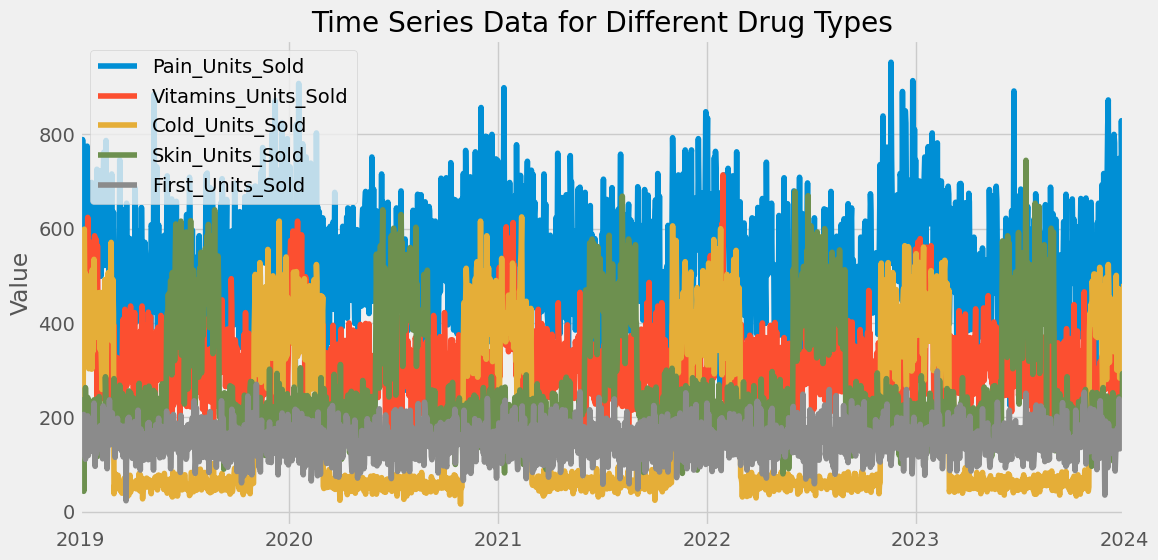

In [84]:
plt.figure(figsize=(12, 6))

for column in fourth_join.columns:
    if column != 'Date':
        plt.plot(fourth_join['Date'], fourth_join[column], label= column)

plt.title('Time Series Data for Different Drug Types')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y')) 
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xlim(pd.Timestamp('2019-01-01'), pd.Timestamp('2024-01-01'))
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Let's explore and build a model on the revenue of each individual category first. Let's do Pain Relievers first.

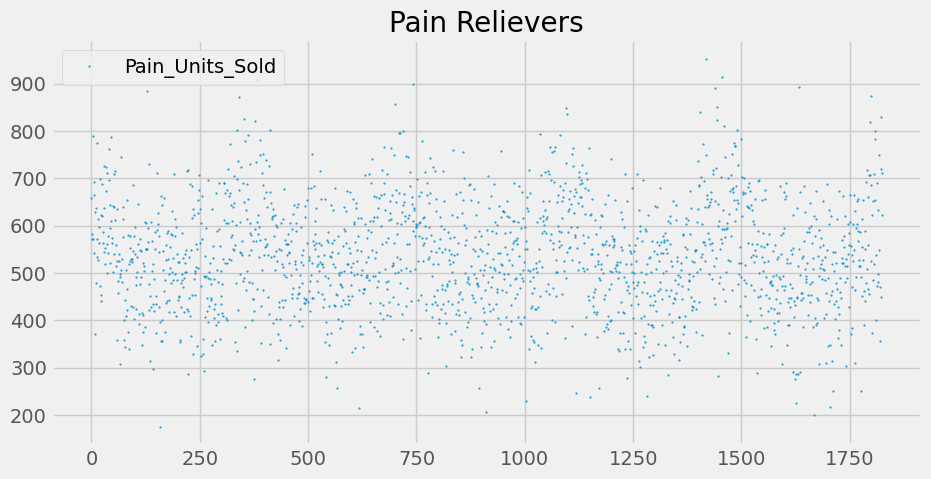

In [77]:
color_pal = sns.color_palette()
painrelievers.plot(style = ".", figsize = (10,5), ms = 1, color = color_pal[0], title = 'Pain Relievers')
plt.show()

In [7]:
painrelievers['Date'] = pd.to_datetime(painrelievers['Date'])

In [8]:
painrelievers.set_index('Date', inplace=True)


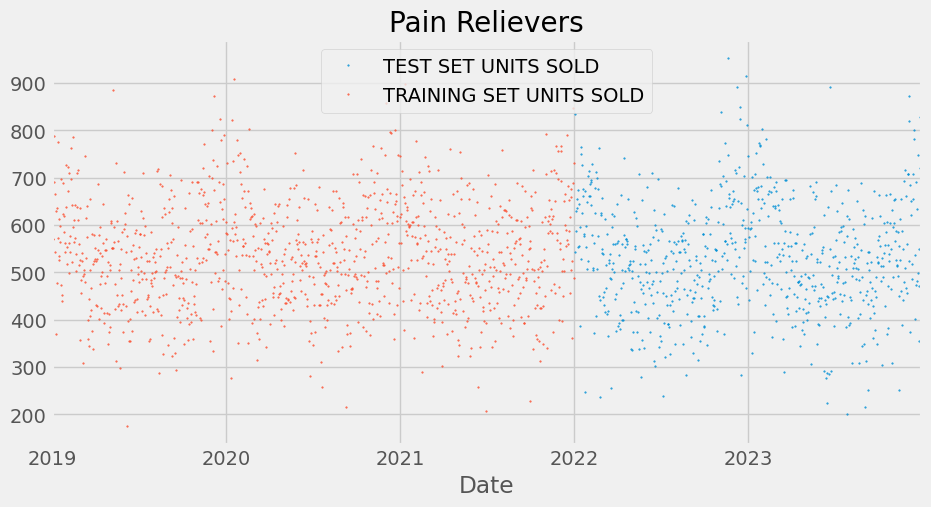

In [9]:
split_date = '2022-01-01'
painrelievers_train = painrelievers.loc[painrelievers.index <= split_date].copy()
painrelievers_test = painrelievers.loc[painrelievers.index > split_date].copy()

painrelievers_train = painrelievers_train.rename(columns={'Units_Sold': 'TRAINING SET UNITS SOLD'})
painrelievers_test = painrelievers_test.rename(columns={'Units_Sold': 'TEST SET UNITS SOLD'})

painrelievers_test.join(painrelievers_train, how='outer', lsuffix='_test', rsuffix='_train') \
    .plot(figsize=(10, 5), title='Pain Relievers', style='.', ms=1)

plt.show()

In [10]:
painrelievers_prophet = painrelievers_train.reset_index() \
    .rename(columns={'Date':'ds',
                     'TRAINING SET UNITS SOLD':'y'})

In [11]:
model = Prophet()
model.fit(painrelievers_prophet)

21:46:23 - cmdstanpy - INFO - Chain [1] start processing
21:46:23 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
painrelievers_test_prophet = painrelievers_test.reset_index() \
    .rename(columns={'Date':'ds',
                     'TEST SET UNITS SOLD':'y'})

test_results = model.predict(painrelievers_test_prophet)

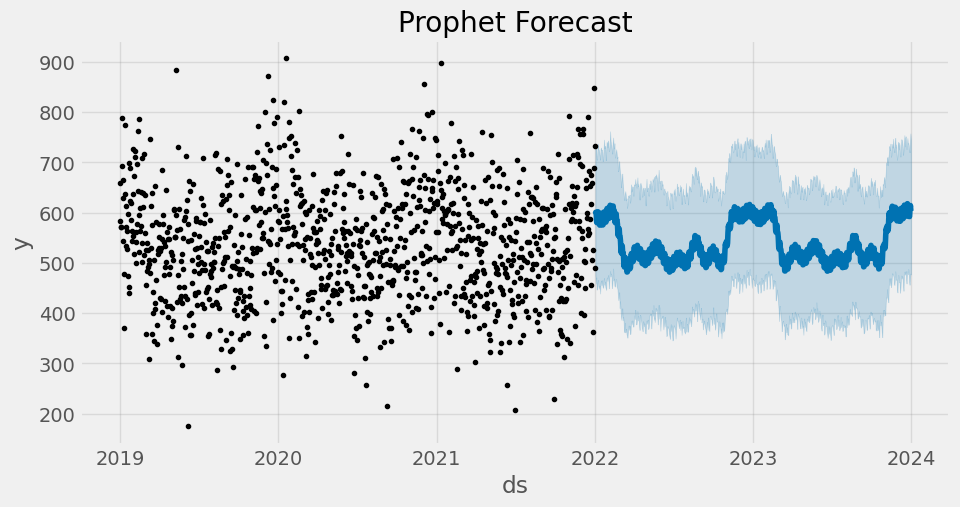

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(test_results, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

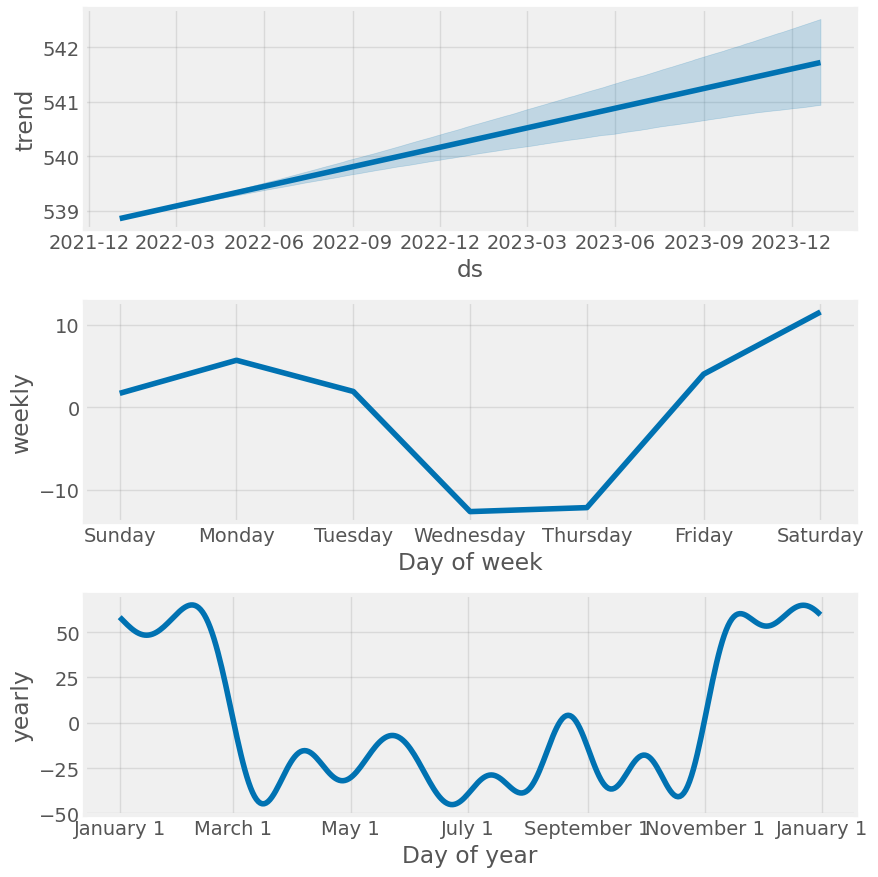

In [14]:
fig = model.plot_components(test_results)
plt.show()

# Evaluation Metrics

In [15]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/y_true)) * 100

In [16]:
test_yhat = test_results[['ds', 'yhat']]

In [17]:
merged_df = pd.merge(painrelievers_test_prophet, test_yhat)

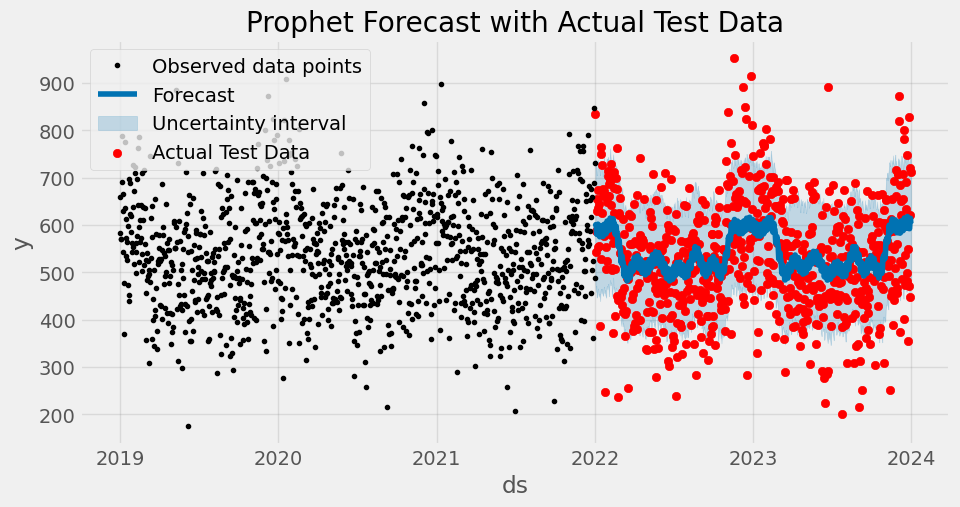

In [18]:

fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(test_results, ax=ax)

ax.scatter(painrelievers_test_prophet['ds'], painrelievers_test_prophet['y'], color='r', label='Actual Test Data')

ax.legend()


ax.set_title('Prophet Forecast with Actual Test Data')

plt.show()


In [19]:
np.sqrt(mean_squared_error(y_true=painrelievers_test_prophet['y'],
                   y_pred=test_results['yhat']))

109.11914383814286

In [20]:
mean_absolute_error(y_true=painrelievers_test_prophet['y'],
                   y_pred=test_results['yhat'])

86.78276695746484

In [21]:
mean_absolute_percentage_error(y_true=painrelievers_test_prophet['y'],
                   y_pred=test_results['yhat'])

18.508091978254107

# Cross Validation

In [22]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
df_cv = cross_validation(model, initial = '730 days', period = '180 days', horizon = '365 days')

  0%|          | 0/1 [00:00<?, ?it/s]

21:46:24 - cmdstanpy - INFO - Chain [1] start processing
21:46:24 - cmdstanpy - INFO - Chain [1] done processing


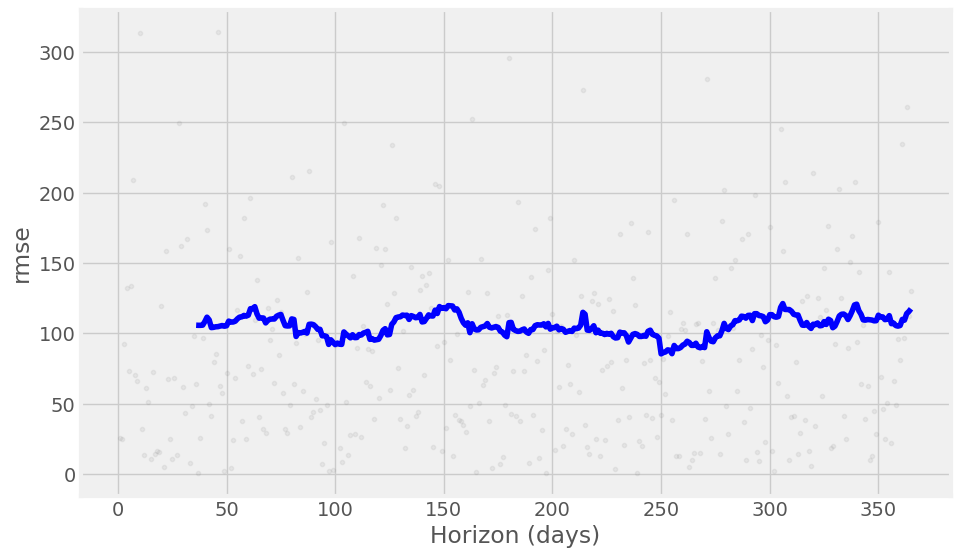

In [23]:
from prophet.plot import plot_cross_validation_metric

fig = plot_cross_validation_metric(df_cv, metric='rmse')


# Grid Search

In [24]:

param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [1.0, 5.0, 10.0],
    'holidays_prior_scale': [1.0, 10.0, 20.0]
}

best_params = None
best_rmse = float('inf')

for changepoint in param_grid['changepoint_prior_scale']:
    for seasonality in param_grid['seasonality_prior_scale']:
        for holiday in param_grid['holidays_prior_scale']:
            model = Prophet(
                changepoint_prior_scale=changepoint,
                seasonality_prior_scale=seasonality,
                holidays_prior_scale = holiday
            )
            model.fit(painrelievers_prophet)
    
            df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='365 days')
            df_p = performance_metrics(df_cv)
    
            if df_p['rmse'].mean() < best_rmse:
                best_rmse = df_p['rmse'].mean()
                best_params = {
                    'changepoint_prior_scale': changepoint,
                    'seasonality_prior_scale': seasonality,
                    'holiday_prior_scale': holiday
                }

print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)


21:46:24 - cmdstanpy - INFO - Chain [1] start processing
21:46:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:24 - cmdstanpy - INFO - Chain [1] start processing
21:46:24 - cmdstanpy - INFO - Chain [1] done processing
21:46:25 - cmdstanpy - INFO - Chain [1] start processing
21:46:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:25 - cmdstanpy - INFO - Chain [1] start processing
21:46:25 - cmdstanpy - INFO - Chain [1] done processing
21:46:25 - cmdstanpy - INFO - Chain [1] start processing
21:46:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:25 - cmdstanpy - INFO - Chain [1] start processing
21:46:25 - cmdstanpy - INFO - Chain [1] done processing
21:46:25 - cmdstanpy - INFO - Chain [1] start processing
21:46:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:25 - cmdstanpy - INFO - Chain [1] start processing
21:46:26 - cmdstanpy - INFO - Chain [1] done processing
21:46:26 - cmdstanpy - INFO - Chain [1] start processing
21:46:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:26 - cmdstanpy - INFO - Chain [1] start processing
21:46:26 - cmdstanpy - INFO - Chain [1] done processing
21:46:26 - cmdstanpy - INFO - Chain [1] start processing
21:46:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:26 - cmdstanpy - INFO - Chain [1] start processing
21:46:26 - cmdstanpy - INFO - Chain [1] done processing
21:46:26 - cmdstanpy - INFO - Chain [1] start processing
21:46:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:27 - cmdstanpy - INFO - Chain [1] start processing
21:46:27 - cmdstanpy - INFO - Chain [1] done processing
21:46:27 - cmdstanpy - INFO - Chain [1] start processing
21:46:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:27 - cmdstanpy - INFO - Chain [1] start processing
21:46:27 - cmdstanpy - INFO - Chain [1] done processing
21:46:27 - cmdstanpy - INFO - Chain [1] start processing
21:46:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:27 - cmdstanpy - INFO - Chain [1] start processing
21:46:27 - cmdstanpy - INFO - Chain [1] done processing
21:46:28 - cmdstanpy - INFO - Chain [1] start processing
21:46:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:28 - cmdstanpy - INFO - Chain [1] start processing
21:46:28 - cmdstanpy - INFO - Chain [1] done processing
21:46:28 - cmdstanpy - INFO - Chain [1] start processing
21:46:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:28 - cmdstanpy - INFO - Chain [1] start processing
21:46:28 - cmdstanpy - INFO - Chain [1] done processing
21:46:28 - cmdstanpy - INFO - Chain [1] start processing
21:46:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:28 - cmdstanpy - INFO - Chain [1] start processing
21:46:28 - cmdstanpy - INFO - Chain [1] done processing
21:46:29 - cmdstanpy - INFO - Chain [1] start processing
21:46:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:29 - cmdstanpy - INFO - Chain [1] start processing
21:46:29 - cmdstanpy - INFO - Chain [1] done processing
21:46:29 - cmdstanpy - INFO - Chain [1] start processing
21:46:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:29 - cmdstanpy - INFO - Chain [1] start processing
21:46:29 - cmdstanpy - INFO - Chain [1] done processing
21:46:29 - cmdstanpy - INFO - Chain [1] start processing
21:46:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:29 - cmdstanpy - INFO - Chain [1] start processing
21:46:29 - cmdstanpy - INFO - Chain [1] done processing
21:46:30 - cmdstanpy - INFO - Chain [1] start processing
21:46:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:30 - cmdstanpy - INFO - Chain [1] start processing
21:46:30 - cmdstanpy - INFO - Chain [1] done processing
21:46:30 - cmdstanpy - INFO - Chain [1] start processing
21:46:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:30 - cmdstanpy - INFO - Chain [1] start processing
21:46:30 - cmdstanpy - INFO - Chain [1] done processing
21:46:30 - cmdstanpy - INFO - Chain [1] start processing
21:46:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:30 - cmdstanpy - INFO - Chain [1] start processing
21:46:30 - cmdstanpy - INFO - Chain [1] done processing
21:46:31 - cmdstanpy - INFO - Chain [1] start processing
21:46:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:31 - cmdstanpy - INFO - Chain [1] start processing
21:46:31 - cmdstanpy - INFO - Chain [1] done processing
21:46:31 - cmdstanpy - INFO - Chain [1] start processing
21:46:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:31 - cmdstanpy - INFO - Chain [1] start processing
21:46:31 - cmdstanpy - INFO - Chain [1] done processing
21:46:31 - cmdstanpy - INFO - Chain [1] start processing
21:46:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:31 - cmdstanpy - INFO - Chain [1] start processing
21:46:31 - cmdstanpy - INFO - Chain [1] done processing
21:46:32 - cmdstanpy - INFO - Chain [1] start processing
21:46:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:32 - cmdstanpy - INFO - Chain [1] start processing
21:46:32 - cmdstanpy - INFO - Chain [1] done processing
21:46:32 - cmdstanpy - INFO - Chain [1] start processing
21:46:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:32 - cmdstanpy - INFO - Chain [1] start processing
21:46:32 - cmdstanpy - INFO - Chain [1] done processing
21:46:32 - cmdstanpy - INFO - Chain [1] start processing
21:46:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:32 - cmdstanpy - INFO - Chain [1] start processing
21:46:32 - cmdstanpy - INFO - Chain [1] done processing
21:46:33 - cmdstanpy - INFO - Chain [1] start processing
21:46:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:33 - cmdstanpy - INFO - Chain [1] start processing
21:46:33 - cmdstanpy - INFO - Chain [1] done processing
21:46:33 - cmdstanpy - INFO - Chain [1] start processing
21:46:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:33 - cmdstanpy - INFO - Chain [1] start processing
21:46:33 - cmdstanpy - INFO - Chain [1] done processing
21:46:33 - cmdstanpy - INFO - Chain [1] start processing
21:46:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:33 - cmdstanpy - INFO - Chain [1] start processing
21:46:33 - cmdstanpy - INFO - Chain [1] done processing


Best Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holiday_prior_scale': 1.0}
Best RMSE: 105.03513222114127


# Predictions

Let's initialize a new model with the optimal parameters, changepoint_prior_scale = 0.5, seasonality_prior_scale = 10.0, holiday_prior_scale = 1.0.

In [25]:
final_model = Prophet(
    changepoint_prior_scale=0.5,
    seasonality_prior_scale = 10.0,
    holidays_prior_scale= 1.0
)


final_model.fit(painrelievers_prophet)

21:46:34 - cmdstanpy - INFO - Chain [1] start processing
21:46:34 - cmdstanpy - INFO - Chain [1] done processing


In [26]:

future = final_model.make_future_dataframe(periods=365 * 10, freq='d', include_history=True)
forecast = final_model.predict(future)

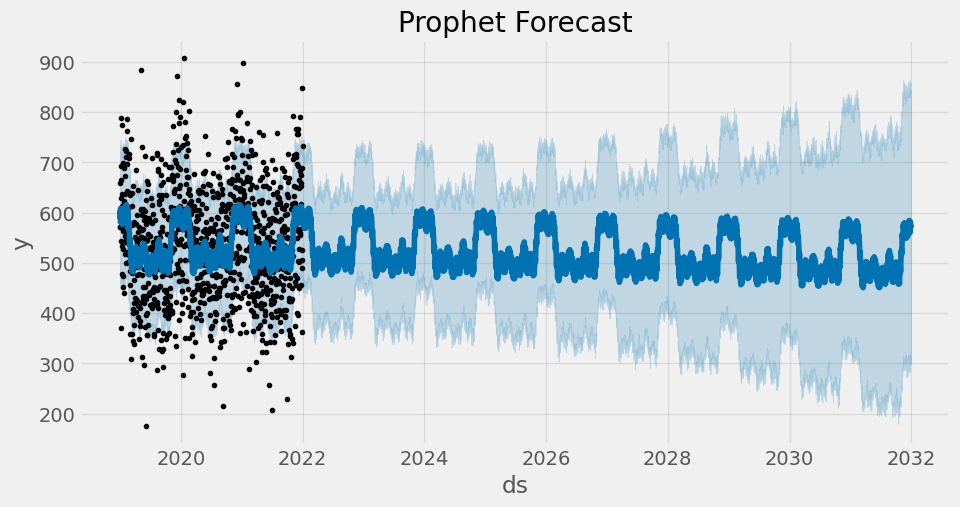

In [27]:
forecast_columns = ['ds', 'yhat', 'yhat_lower', 'yhat_upper']
forecast_results = forecast[forecast_columns]
fig, ax = plt.subplots(figsize=(10, 5))
fig = final_model.plot(forecast_results, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

# Let's now apply this analysis to other classes.

# Vitamins

In [28]:
import pandas as pd
from TimeSeriesClass import TimeSeriesProphet

In [29]:
data = pd.read_csv("healthcare_product_sales.csv")
drug_name = "Vitamins"
ts_prophet_vitamins = TimeSeriesProphet(data,drug_name)  
ts_prophet_vitamins.error()

21:46:34 - cmdstanpy - INFO - Chain [1] start processing
21:46:34 - cmdstanpy - INFO - Chain [1] done processing


(65.31465496056904, 51.08165109944306, 17.834689691331786)

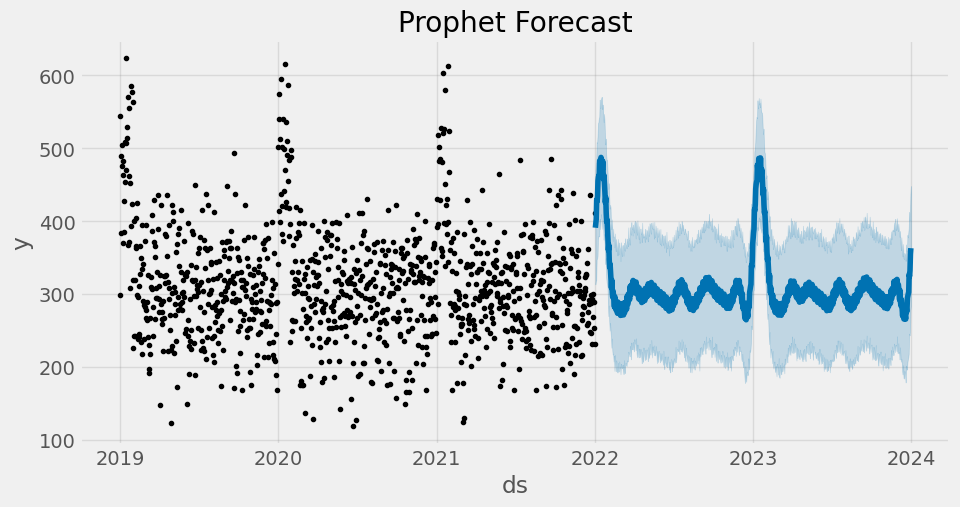

In [30]:
ts_prophet_vitamins.forecast_diagram()

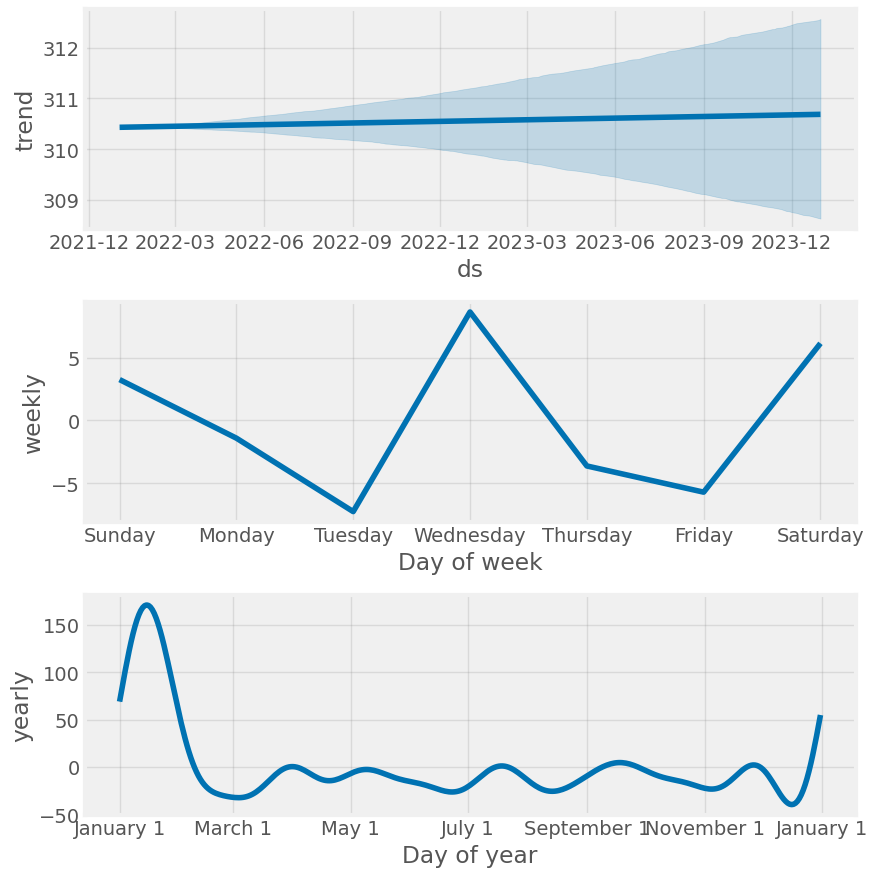

In [31]:
ts_prophet_vitamins.components()

# Cold Remedies

21:46:35 - cmdstanpy - INFO - Chain [1] start processing
21:46:35 - cmdstanpy - INFO - Chain [1] done processing


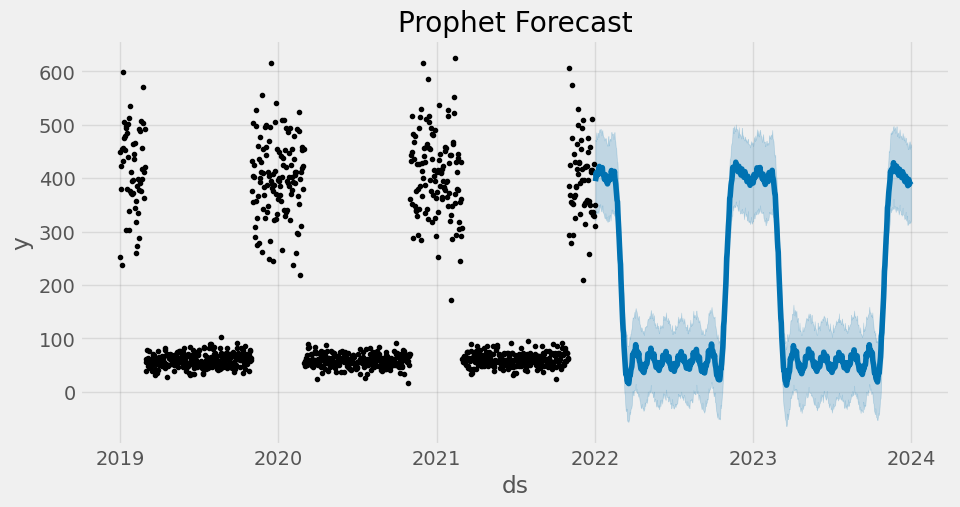

In [32]:

drug_name = "Cold Remedies"
ts_prophet_cold = TimeSeriesProphet(data,drug_name)    
ts_prophet_cold.forecast_diagram()

In [33]:
ts_prophet_cold.error()

(58.011356321771665, 37.076796952156684, 29.883429833313123)

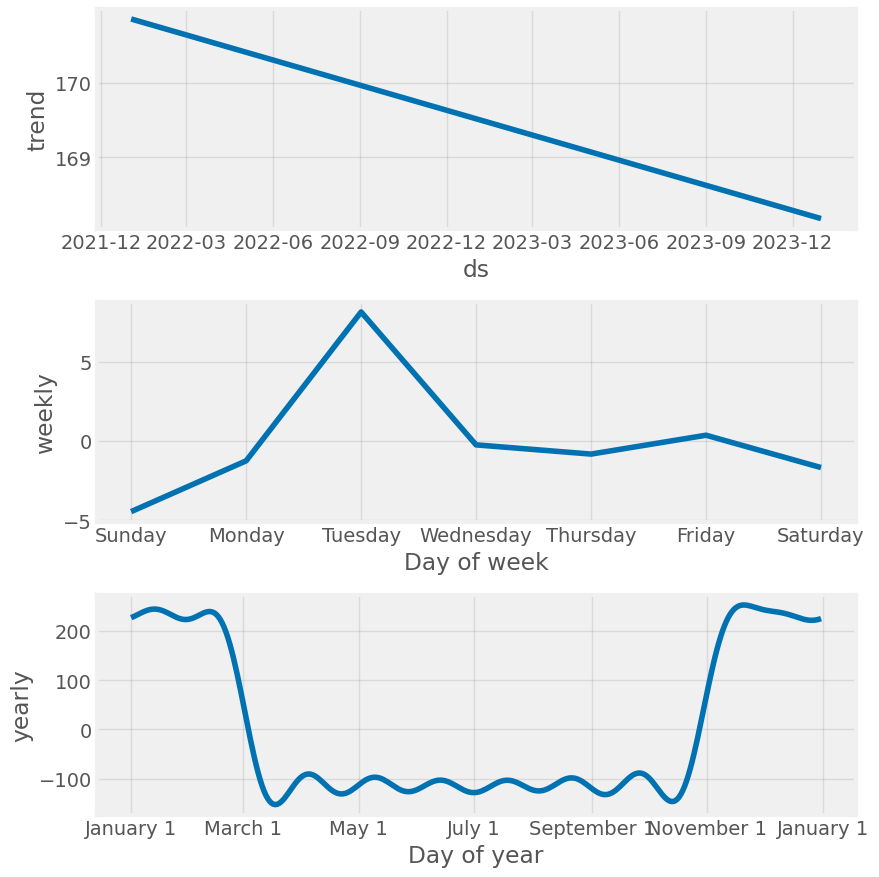

In [34]:
ts_prophet_cold.components()

# Skin Care

21:46:36 - cmdstanpy - INFO - Chain [1] start processing
21:46:36 - cmdstanpy - INFO - Chain [1] done processing


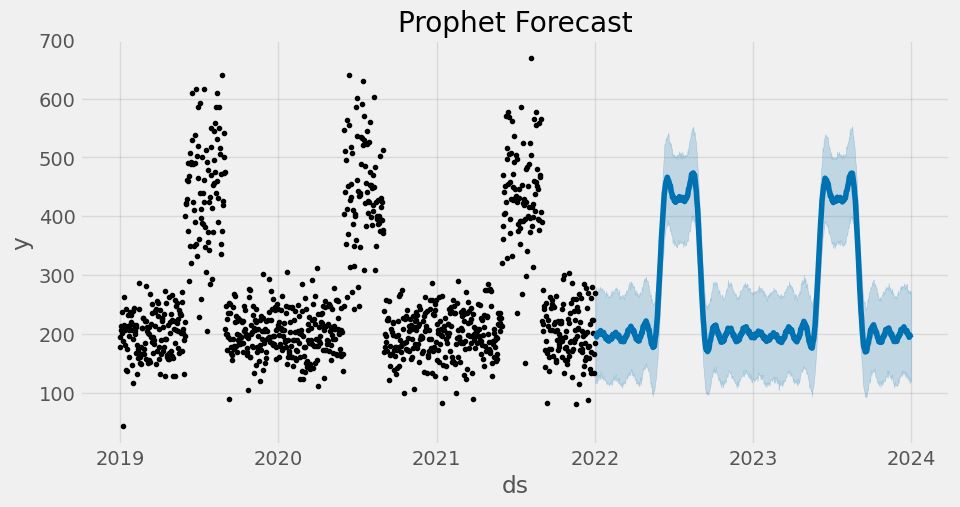

In [35]:

drug_name = "Skin Care"
ts_prophet_skin_care = TimeSeriesProphet(data,drug_name)
ts_prophet_skin_care.error()
ts_prophet_skin_care.forecast_diagram()

In [36]:
ts_prophet_skin_care.error()

(62.30356220927285, 44.57480118940957, 18.277263277069277)

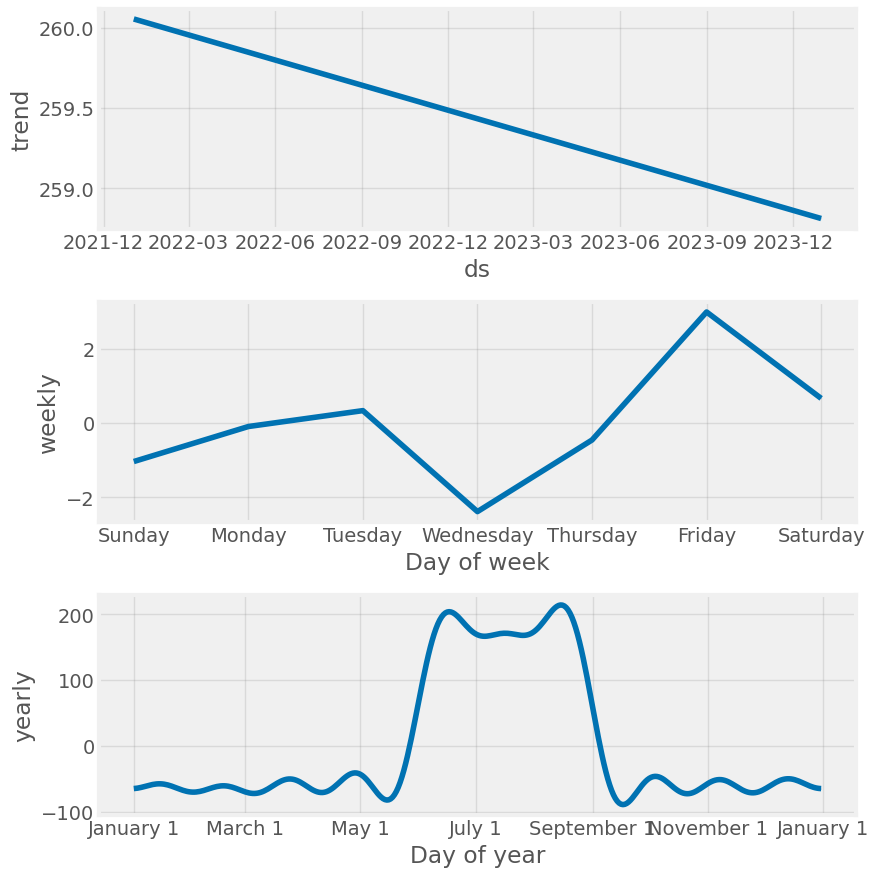

In [37]:
ts_prophet_skin_care.components()

# First Aid

21:46:36 - cmdstanpy - INFO - Chain [1] start processing
21:46:36 - cmdstanpy - INFO - Chain [1] done processing


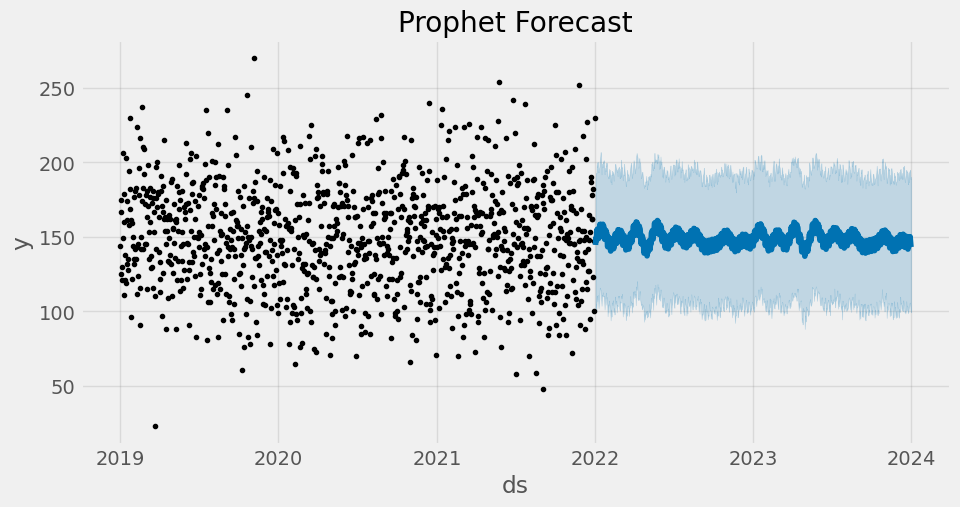

In [38]:

drug_name = "First Aid Supplies"
ts_prophet_fa = TimeSeriesProphet(data,drug_name)
ts_prophet_fa.error()
ts_prophet_fa.forecast_diagram()

In [39]:
ts_prophet_fa.error()

(35.75715532276059, 27.9707382874793, 19.659342315153935)

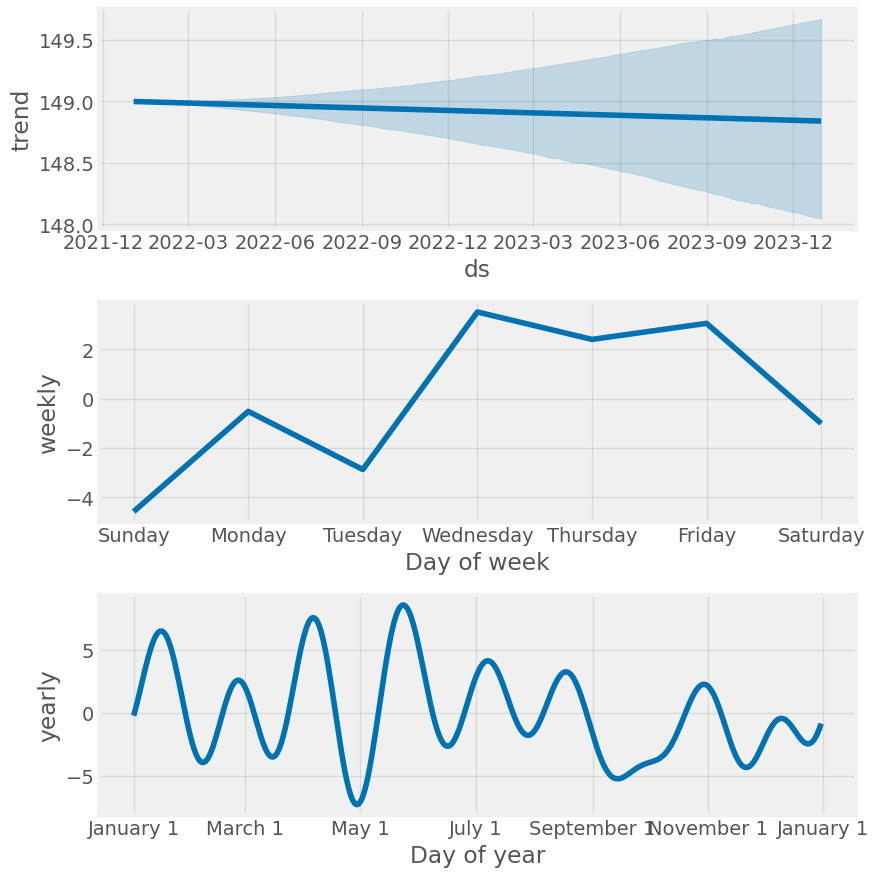

In [40]:
ts_prophet_fa.components()

# Reviewing Other Categories But With Cross-Validation

# Vitamins

In [41]:

from TimeSeriesClass import TimeSeriesProphet
from TimeSeriesClass import ProphetCV

data = pd.read_csv("healthcare_product_sales.csv")
drug_name = "Vitamins"
ts_prophet_vitamins = TimeSeriesProphet(data,drug_name)  
ts_prophet_cv_vitamins = ProphetCV(data,drug_name)

21:46:37 - cmdstanpy - INFO - Chain [1] start processing
21:46:37 - cmdstanpy - INFO - Chain [1] done processing
21:46:37 - cmdstanpy - INFO - Chain [1] start processing
21:46:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:38 - cmdstanpy - INFO - Chain [1] start processing
21:46:38 - cmdstanpy - INFO - Chain [1] done processing


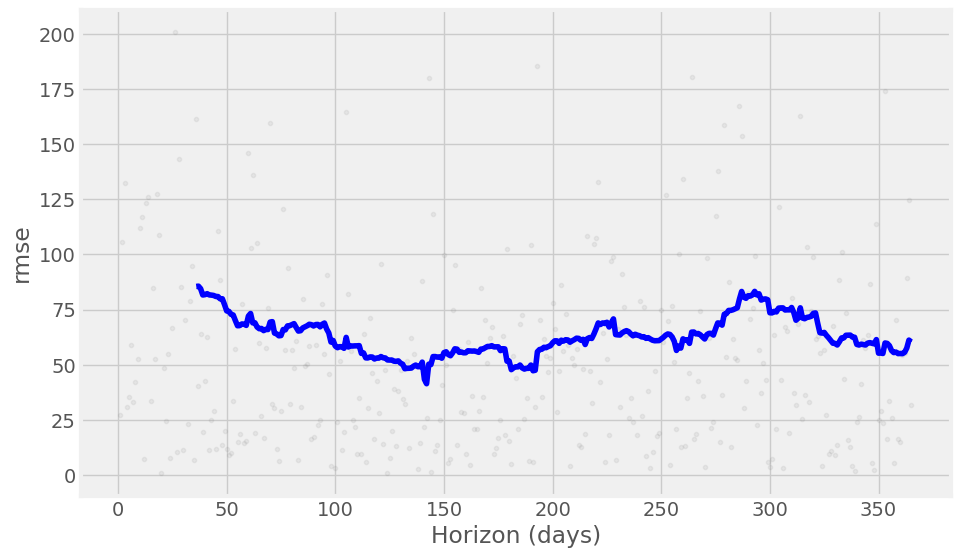

In [42]:
ts_prophet_cv_vitamins.generalization()

In [43]:
ts_prophet_cv_vitamins.grid_search()

21:46:38 - cmdstanpy - INFO - Chain [1] start processing
21:46:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:38 - cmdstanpy - INFO - Chain [1] start processing
21:46:38 - cmdstanpy - INFO - Chain [1] done processing
21:46:38 - cmdstanpy - INFO - Chain [1] start processing
21:46:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:38 - cmdstanpy - INFO - Chain [1] start processing
21:46:38 - cmdstanpy - INFO - Chain [1] done processing
21:46:38 - cmdstanpy - INFO - Chain [1] start processing
21:46:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:39 - cmdstanpy - INFO - Chain [1] start processing
21:46:39 - cmdstanpy - INFO - Chain [1] done processing
21:46:39 - cmdstanpy - INFO - Chain [1] start processing
21:46:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:39 - cmdstanpy - INFO - Chain [1] start processing
21:46:39 - cmdstanpy - INFO - Chain [1] done processing
21:46:39 - cmdstanpy - INFO - Chain [1] start processing
21:46:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:39 - cmdstanpy - INFO - Chain [1] start processing
21:46:39 - cmdstanpy - INFO - Chain [1] done processing
21:46:40 - cmdstanpy - INFO - Chain [1] start processing
21:46:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:40 - cmdstanpy - INFO - Chain [1] start processing
21:46:40 - cmdstanpy - INFO - Chain [1] done processing
21:46:40 - cmdstanpy - INFO - Chain [1] start processing
21:46:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:40 - cmdstanpy - INFO - Chain [1] start processing
21:46:40 - cmdstanpy - INFO - Chain [1] done processing
21:46:40 - cmdstanpy - INFO - Chain [1] start processing
21:46:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:40 - cmdstanpy - INFO - Chain [1] start processing
21:46:40 - cmdstanpy - INFO - Chain [1] done processing
21:46:41 - cmdstanpy - INFO - Chain [1] start processing
21:46:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:41 - cmdstanpy - INFO - Chain [1] start processing
21:46:41 - cmdstanpy - INFO - Chain [1] done processing
21:46:41 - cmdstanpy - INFO - Chain [1] start processing
21:46:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:41 - cmdstanpy - INFO - Chain [1] start processing
21:46:41 - cmdstanpy - INFO - Chain [1] done processing
21:46:41 - cmdstanpy - INFO - Chain [1] start processing
21:46:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:41 - cmdstanpy - INFO - Chain [1] start processing
21:46:41 - cmdstanpy - INFO - Chain [1] done processing
21:46:42 - cmdstanpy - INFO - Chain [1] start processing
21:46:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:42 - cmdstanpy - INFO - Chain [1] start processing
21:46:42 - cmdstanpy - INFO - Chain [1] done processing
21:46:42 - cmdstanpy - INFO - Chain [1] start processing
21:46:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:42 - cmdstanpy - INFO - Chain [1] start processing
21:46:42 - cmdstanpy - INFO - Chain [1] done processing
21:46:42 - cmdstanpy - INFO - Chain [1] start processing
21:46:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:42 - cmdstanpy - INFO - Chain [1] start processing
21:46:42 - cmdstanpy - INFO - Chain [1] done processing
21:46:43 - cmdstanpy - INFO - Chain [1] start processing
21:46:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:43 - cmdstanpy - INFO - Chain [1] start processing
21:46:43 - cmdstanpy - INFO - Chain [1] done processing
21:46:43 - cmdstanpy - INFO - Chain [1] start processing
21:46:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:43 - cmdstanpy - INFO - Chain [1] start processing
21:46:43 - cmdstanpy - INFO - Chain [1] done processing
21:46:43 - cmdstanpy - INFO - Chain [1] start processing
21:46:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:43 - cmdstanpy - INFO - Chain [1] start processing
21:46:43 - cmdstanpy - INFO - Chain [1] done processing
21:46:44 - cmdstanpy - INFO - Chain [1] start processing
21:46:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:44 - cmdstanpy - INFO - Chain [1] start processing
21:46:44 - cmdstanpy - INFO - Chain [1] done processing
21:46:44 - cmdstanpy - INFO - Chain [1] start processing
21:46:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:44 - cmdstanpy - INFO - Chain [1] start processing
21:46:44 - cmdstanpy - INFO - Chain [1] done processing
21:46:44 - cmdstanpy - INFO - Chain [1] start processing
21:46:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:44 - cmdstanpy - INFO - Chain [1] start processing
21:46:44 - cmdstanpy - INFO - Chain [1] done processing
21:46:45 - cmdstanpy - INFO - Chain [1] start processing
21:46:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:45 - cmdstanpy - INFO - Chain [1] start processing
21:46:45 - cmdstanpy - INFO - Chain [1] done processing
21:46:45 - cmdstanpy - INFO - Chain [1] start processing
21:46:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:45 - cmdstanpy - INFO - Chain [1] start processing
21:46:45 - cmdstanpy - INFO - Chain [1] done processing
21:46:45 - cmdstanpy - INFO - Chain [1] start processing
21:46:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:46 - cmdstanpy - INFO - Chain [1] start processing
21:46:46 - cmdstanpy - INFO - Chain [1] done processing
21:46:46 - cmdstanpy - INFO - Chain [1] start processing
21:46:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:46 - cmdstanpy - INFO - Chain [1] start processing
21:46:46 - cmdstanpy - INFO - Chain [1] done processing
21:46:46 - cmdstanpy - INFO - Chain [1] start processing
21:46:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:46 - cmdstanpy - INFO - Chain [1] start processing
21:46:46 - cmdstanpy - INFO - Chain [1] done processing
21:46:47 - cmdstanpy - INFO - Chain [1] start processing
21:46:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:47 - cmdstanpy - INFO - Chain [1] start processing
21:46:47 - cmdstanpy - INFO - Chain [1] done processing
21:46:47 - cmdstanpy - INFO - Chain [1] start processing
21:46:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:47 - cmdstanpy - INFO - Chain [1] start processing
21:46:47 - cmdstanpy - INFO - Chain [1] done processing


Best Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0}
Best RMSE: 62.17823196404362


{'changepoint_prior_scale': 0.5,
 'seasonality_prior_scale': 1.0,
 'holidays_prior_scale': 1.0}

21:46:47 - cmdstanpy - INFO - Chain [1] start processing
21:46:47 - cmdstanpy - INFO - Chain [1] done processing


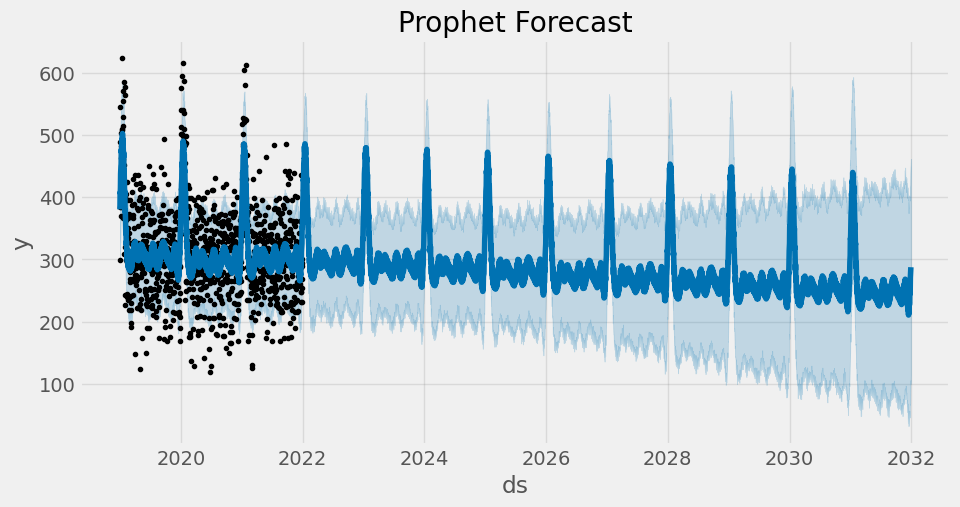

In [44]:
ts_prophet_cv_vitamins.predict_optimal_graph(10)

# Cold Remedies

In [45]:

drug_name = "Cold Remedies"
ts_prophet_cold = TimeSeriesProphet(data,drug_name)  
ts_prophet_cv_cold = ProphetCV(data,drug_name)

21:46:48 - cmdstanpy - INFO - Chain [1] start processing
21:46:48 - cmdstanpy - INFO - Chain [1] done processing
21:46:48 - cmdstanpy - INFO - Chain [1] start processing
21:46:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:49 - cmdstanpy - INFO - Chain [1] start processing
21:46:49 - cmdstanpy - INFO - Chain [1] done processing


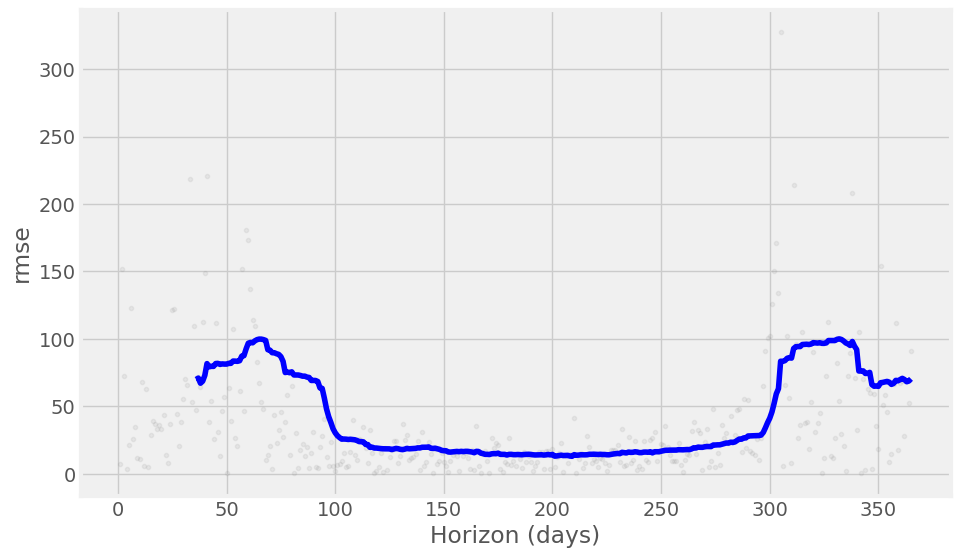

In [46]:
ts_prophet_cv_cold.generalization()

In [47]:
ts_prophet_cv_cold.grid_search()

21:46:49 - cmdstanpy - INFO - Chain [1] start processing
21:46:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:49 - cmdstanpy - INFO - Chain [1] start processing
21:46:49 - cmdstanpy - INFO - Chain [1] done processing
21:46:49 - cmdstanpy - INFO - Chain [1] start processing
21:46:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:49 - cmdstanpy - INFO - Chain [1] start processing
21:46:49 - cmdstanpy - INFO - Chain [1] done processing
21:46:50 - cmdstanpy - INFO - Chain [1] start processing
21:46:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:50 - cmdstanpy - INFO - Chain [1] start processing
21:46:50 - cmdstanpy - INFO - Chain [1] done processing
21:46:50 - cmdstanpy - INFO - Chain [1] start processing
21:46:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:50 - cmdstanpy - INFO - Chain [1] start processing
21:46:50 - cmdstanpy - INFO - Chain [1] done processing
21:46:50 - cmdstanpy - INFO - Chain [1] start processing
21:46:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:50 - cmdstanpy - INFO - Chain [1] start processing
21:46:50 - cmdstanpy - INFO - Chain [1] done processing
21:46:50 - cmdstanpy - INFO - Chain [1] start processing
21:46:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:50 - cmdstanpy - INFO - Chain [1] start processing
21:46:50 - cmdstanpy - INFO - Chain [1] done processing
21:46:51 - cmdstanpy - INFO - Chain [1] start processing
21:46:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:51 - cmdstanpy - INFO - Chain [1] start processing
21:46:51 - cmdstanpy - INFO - Chain [1] done processing
21:46:51 - cmdstanpy - INFO - Chain [1] start processing
21:46:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:51 - cmdstanpy - INFO - Chain [1] start processing
21:46:51 - cmdstanpy - INFO - Chain [1] done processing
21:46:51 - cmdstanpy - INFO - Chain [1] start processing
21:46:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:51 - cmdstanpy - INFO - Chain [1] start processing
21:46:51 - cmdstanpy - INFO - Chain [1] done processing
21:46:52 - cmdstanpy - INFO - Chain [1] start processing
21:46:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:52 - cmdstanpy - INFO - Chain [1] start processing
21:46:52 - cmdstanpy - INFO - Chain [1] done processing
21:46:52 - cmdstanpy - INFO - Chain [1] start processing
21:46:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:52 - cmdstanpy - INFO - Chain [1] start processing
21:46:52 - cmdstanpy - INFO - Chain [1] done processing
21:46:52 - cmdstanpy - INFO - Chain [1] start processing
21:46:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:52 - cmdstanpy - INFO - Chain [1] start processing
21:46:52 - cmdstanpy - INFO - Chain [1] done processing
21:46:53 - cmdstanpy - INFO - Chain [1] start processing
21:46:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:53 - cmdstanpy - INFO - Chain [1] start processing
21:46:53 - cmdstanpy - INFO - Chain [1] done processing
21:46:53 - cmdstanpy - INFO - Chain [1] start processing
21:46:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:53 - cmdstanpy - INFO - Chain [1] start processing
21:46:53 - cmdstanpy - INFO - Chain [1] done processing
21:46:53 - cmdstanpy - INFO - Chain [1] start processing
21:46:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:53 - cmdstanpy - INFO - Chain [1] start processing
21:46:54 - cmdstanpy - INFO - Chain [1] done processing
21:46:54 - cmdstanpy - INFO - Chain [1] start processing
21:46:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:54 - cmdstanpy - INFO - Chain [1] start processing
21:46:54 - cmdstanpy - INFO - Chain [1] done processing
21:46:54 - cmdstanpy - INFO - Chain [1] start processing
21:46:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:54 - cmdstanpy - INFO - Chain [1] start processing
21:46:54 - cmdstanpy - INFO - Chain [1] done processing
21:46:54 - cmdstanpy - INFO - Chain [1] start processing
21:46:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:54 - cmdstanpy - INFO - Chain [1] start processing
21:46:55 - cmdstanpy - INFO - Chain [1] done processing
21:46:55 - cmdstanpy - INFO - Chain [1] start processing
21:46:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:55 - cmdstanpy - INFO - Chain [1] start processing
21:46:55 - cmdstanpy - INFO - Chain [1] done processing
21:46:55 - cmdstanpy - INFO - Chain [1] start processing
21:46:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:55 - cmdstanpy - INFO - Chain [1] start processing
21:46:55 - cmdstanpy - INFO - Chain [1] done processing
21:46:56 - cmdstanpy - INFO - Chain [1] start processing
21:46:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:56 - cmdstanpy - INFO - Chain [1] start processing
21:46:56 - cmdstanpy - INFO - Chain [1] done processing
21:46:56 - cmdstanpy - INFO - Chain [1] start processing
21:46:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:56 - cmdstanpy - INFO - Chain [1] start processing
21:46:56 - cmdstanpy - INFO - Chain [1] done processing
21:46:56 - cmdstanpy - INFO - Chain [1] start processing
21:46:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:56 - cmdstanpy - INFO - Chain [1] start processing
21:46:56 - cmdstanpy - INFO - Chain [1] done processing
21:46:57 - cmdstanpy - INFO - Chain [1] start processing
21:46:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:57 - cmdstanpy - INFO - Chain [1] start processing
21:46:57 - cmdstanpy - INFO - Chain [1] done processing
21:46:57 - cmdstanpy - INFO - Chain [1] start processing
21:46:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:57 - cmdstanpy - INFO - Chain [1] start processing
21:46:57 - cmdstanpy - INFO - Chain [1] done processing
21:46:57 - cmdstanpy - INFO - Chain [1] start processing
21:46:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:57 - cmdstanpy - INFO - Chain [1] start processing
21:46:57 - cmdstanpy - INFO - Chain [1] done processing
21:46:58 - cmdstanpy - INFO - Chain [1] start processing
21:46:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:58 - cmdstanpy - INFO - Chain [1] start processing
21:46:58 - cmdstanpy - INFO - Chain [1] done processing


Best Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0}
Best RMSE: 42.678327197810006


{'changepoint_prior_scale': 0.01,
 'seasonality_prior_scale': 10.0,
 'holidays_prior_scale': 1.0}

21:46:58 - cmdstanpy - INFO - Chain [1] start processing
21:46:58 - cmdstanpy - INFO - Chain [1] done processing


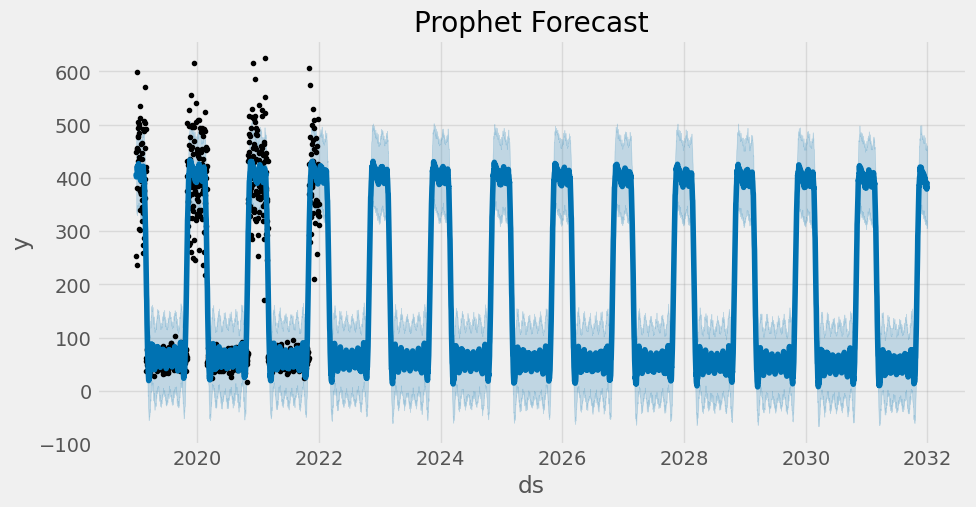

In [48]:
ts_prophet_cv_cold.predict_optimal_graph(10)

# Skin Care

In [49]:
drug_name = "Skin Care"
ts_prophet_skincare = TimeSeriesProphet(data, drug_name)
ts_prophet_cv_skincare = ProphetCV(data,drug_name)

21:46:59 - cmdstanpy - INFO - Chain [1] start processing
21:46:59 - cmdstanpy - INFO - Chain [1] done processing
21:46:59 - cmdstanpy - INFO - Chain [1] start processing
21:46:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:46:59 - cmdstanpy - INFO - Chain [1] start processing
21:46:59 - cmdstanpy - INFO - Chain [1] done processing


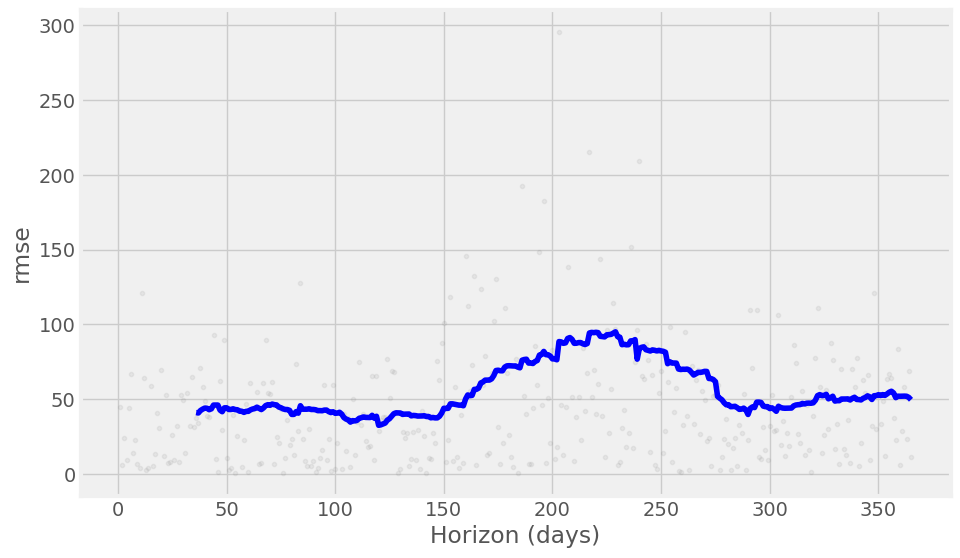

In [50]:
ts_prophet_cv_skincare.generalization()

In [51]:
ts_prophet_cv_skincare.grid_search()

21:47:00 - cmdstanpy - INFO - Chain [1] start processing
21:47:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:00 - cmdstanpy - INFO - Chain [1] start processing
21:47:00 - cmdstanpy - INFO - Chain [1] done processing
21:47:00 - cmdstanpy - INFO - Chain [1] start processing
21:47:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:00 - cmdstanpy - INFO - Chain [1] start processing
21:47:00 - cmdstanpy - INFO - Chain [1] done processing
21:47:00 - cmdstanpy - INFO - Chain [1] start processing
21:47:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:00 - cmdstanpy - INFO - Chain [1] start processing
21:47:00 - cmdstanpy - INFO - Chain [1] done processing
21:47:01 - cmdstanpy - INFO - Chain [1] start processing
21:47:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:01 - cmdstanpy - INFO - Chain [1] start processing
21:47:01 - cmdstanpy - INFO - Chain [1] done processing
21:47:01 - cmdstanpy - INFO - Chain [1] start processing
21:47:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:01 - cmdstanpy - INFO - Chain [1] start processing
21:47:01 - cmdstanpy - INFO - Chain [1] done processing
21:47:01 - cmdstanpy - INFO - Chain [1] start processing
21:47:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:01 - cmdstanpy - INFO - Chain [1] start processing
21:47:01 - cmdstanpy - INFO - Chain [1] done processing
21:47:01 - cmdstanpy - INFO - Chain [1] start processing
21:47:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:02 - cmdstanpy - INFO - Chain [1] start processing
21:47:02 - cmdstanpy - INFO - Chain [1] done processing
21:47:02 - cmdstanpy - INFO - Chain [1] start processing
21:47:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:02 - cmdstanpy - INFO - Chain [1] start processing
21:47:02 - cmdstanpy - INFO - Chain [1] done processing
21:47:02 - cmdstanpy - INFO - Chain [1] start processing
21:47:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:02 - cmdstanpy - INFO - Chain [1] start processing
21:47:02 - cmdstanpy - INFO - Chain [1] done processing
21:47:02 - cmdstanpy - INFO - Chain [1] start processing
21:47:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:03 - cmdstanpy - INFO - Chain [1] start processing
21:47:03 - cmdstanpy - INFO - Chain [1] done processing
21:47:03 - cmdstanpy - INFO - Chain [1] start processing
21:47:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:03 - cmdstanpy - INFO - Chain [1] start processing
21:47:03 - cmdstanpy - INFO - Chain [1] done processing
21:47:03 - cmdstanpy - INFO - Chain [1] start processing
21:47:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:03 - cmdstanpy - INFO - Chain [1] start processing
21:47:03 - cmdstanpy - INFO - Chain [1] done processing
21:47:04 - cmdstanpy - INFO - Chain [1] start processing
21:47:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:04 - cmdstanpy - INFO - Chain [1] start processing
21:47:04 - cmdstanpy - INFO - Chain [1] done processing
21:47:04 - cmdstanpy - INFO - Chain [1] start processing
21:47:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:04 - cmdstanpy - INFO - Chain [1] start processing
21:47:04 - cmdstanpy - INFO - Chain [1] done processing
21:47:04 - cmdstanpy - INFO - Chain [1] start processing
21:47:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:04 - cmdstanpy - INFO - Chain [1] start processing
21:47:04 - cmdstanpy - INFO - Chain [1] done processing
21:47:05 - cmdstanpy - INFO - Chain [1] start processing
21:47:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:05 - cmdstanpy - INFO - Chain [1] start processing
21:47:05 - cmdstanpy - INFO - Chain [1] done processing
21:47:05 - cmdstanpy - INFO - Chain [1] start processing
21:47:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:05 - cmdstanpy - INFO - Chain [1] start processing
21:47:05 - cmdstanpy - INFO - Chain [1] done processing
21:47:05 - cmdstanpy - INFO - Chain [1] start processing
21:47:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:05 - cmdstanpy - INFO - Chain [1] start processing
21:47:05 - cmdstanpy - INFO - Chain [1] done processing
21:47:06 - cmdstanpy - INFO - Chain [1] start processing
21:47:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:06 - cmdstanpy - INFO - Chain [1] start processing
21:47:06 - cmdstanpy - INFO - Chain [1] done processing
21:47:06 - cmdstanpy - INFO - Chain [1] start processing
21:47:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:06 - cmdstanpy - INFO - Chain [1] start processing
21:47:06 - cmdstanpy - INFO - Chain [1] done processing
21:47:06 - cmdstanpy - INFO - Chain [1] start processing
21:47:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:06 - cmdstanpy - INFO - Chain [1] start processing
21:47:06 - cmdstanpy - INFO - Chain [1] done processing
21:47:07 - cmdstanpy - INFO - Chain [1] start processing
21:47:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:07 - cmdstanpy - INFO - Chain [1] start processing
21:47:07 - cmdstanpy - INFO - Chain [1] done processing
21:47:07 - cmdstanpy - INFO - Chain [1] start processing
21:47:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:07 - cmdstanpy - INFO - Chain [1] start processing
21:47:07 - cmdstanpy - INFO - Chain [1] done processing
21:47:07 - cmdstanpy - INFO - Chain [1] start processing
21:47:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:07 - cmdstanpy - INFO - Chain [1] start processing
21:47:07 - cmdstanpy - INFO - Chain [1] done processing
21:47:08 - cmdstanpy - INFO - Chain [1] start processing
21:47:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:08 - cmdstanpy - INFO - Chain [1] start processing
21:47:08 - cmdstanpy - INFO - Chain [1] done processing
21:47:08 - cmdstanpy - INFO - Chain [1] start processing
21:47:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:08 - cmdstanpy - INFO - Chain [1] start processing
21:47:08 - cmdstanpy - INFO - Chain [1] done processing
21:47:08 - cmdstanpy - INFO - Chain [1] start processing
21:47:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:08 - cmdstanpy - INFO - Chain [1] start processing
21:47:09 - cmdstanpy - INFO - Chain [1] done processing


Best Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0}
Best RMSE: 55.54693946627756


{'changepoint_prior_scale': 0.5,
 'seasonality_prior_scale': 1.0,
 'holidays_prior_scale': 1.0}

21:47:09 - cmdstanpy - INFO - Chain [1] start processing
21:47:09 - cmdstanpy - INFO - Chain [1] done processing


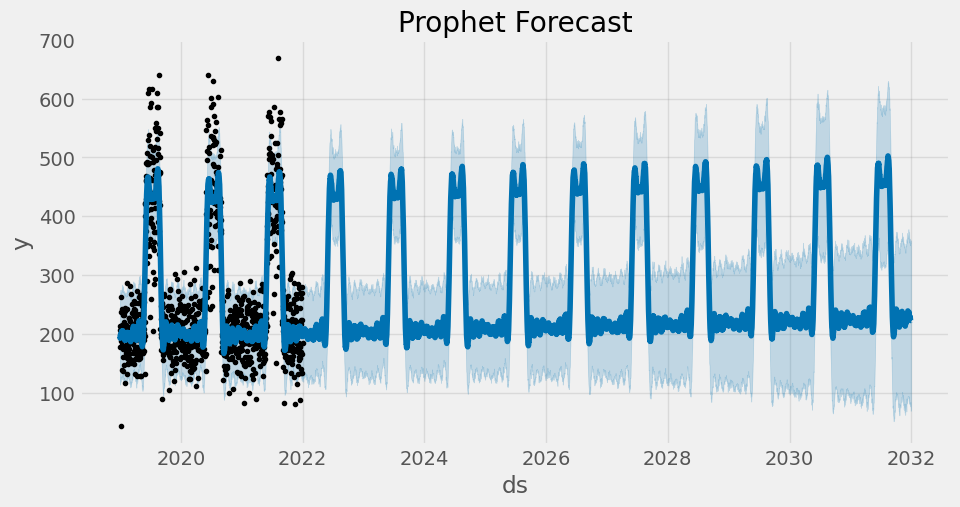

In [52]:
ts_prophet_cv_skincare.predict_optimal_graph(10)

# First Aid

In [53]:
drug_name = "First Aid Supplies"
ts_prophet_first = TimeSeriesProphet(data, drug_name)
ts_prophet_cv_aid = ProphetCV(data,drug_name)

21:47:10 - cmdstanpy - INFO - Chain [1] start processing
21:47:10 - cmdstanpy - INFO - Chain [1] done processing
21:47:10 - cmdstanpy - INFO - Chain [1] start processing
21:47:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:10 - cmdstanpy - INFO - Chain [1] start processing
21:47:10 - cmdstanpy - INFO - Chain [1] done processing


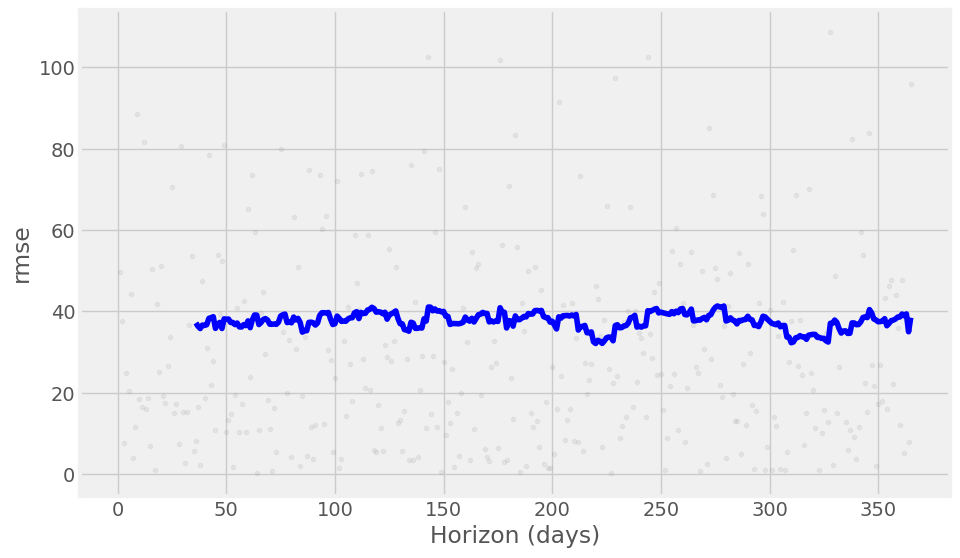

In [54]:
ts_prophet_cv_aid.generalization()

In [55]:
ts_prophet_cv_aid.grid_search()

21:47:10 - cmdstanpy - INFO - Chain [1] start processing
21:47:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:10 - cmdstanpy - INFO - Chain [1] start processing
21:47:10 - cmdstanpy - INFO - Chain [1] done processing
21:47:11 - cmdstanpy - INFO - Chain [1] start processing
21:47:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:11 - cmdstanpy - INFO - Chain [1] start processing
21:47:11 - cmdstanpy - INFO - Chain [1] done processing
21:47:11 - cmdstanpy - INFO - Chain [1] start processing
21:47:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:11 - cmdstanpy - INFO - Chain [1] start processing
21:47:11 - cmdstanpy - INFO - Chain [1] done processing
21:47:11 - cmdstanpy - INFO - Chain [1] start processing
21:47:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:11 - cmdstanpy - INFO - Chain [1] start processing
21:47:11 - cmdstanpy - INFO - Chain [1] done processing
21:47:12 - cmdstanpy - INFO - Chain [1] start processing
21:47:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:12 - cmdstanpy - INFO - Chain [1] start processing
21:47:12 - cmdstanpy - INFO - Chain [1] done processing
21:47:12 - cmdstanpy - INFO - Chain [1] start processing
21:47:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:12 - cmdstanpy - INFO - Chain [1] start processing
21:47:12 - cmdstanpy - INFO - Chain [1] done processing
21:47:12 - cmdstanpy - INFO - Chain [1] start processing
21:47:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:12 - cmdstanpy - INFO - Chain [1] start processing
21:47:12 - cmdstanpy - INFO - Chain [1] done processing
21:47:13 - cmdstanpy - INFO - Chain [1] start processing
21:47:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:13 - cmdstanpy - INFO - Chain [1] start processing
21:47:13 - cmdstanpy - INFO - Chain [1] done processing
21:47:13 - cmdstanpy - INFO - Chain [1] start processing
21:47:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:13 - cmdstanpy - INFO - Chain [1] start processing
21:47:13 - cmdstanpy - INFO - Chain [1] done processing
21:47:13 - cmdstanpy - INFO - Chain [1] start processing
21:47:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:14 - cmdstanpy - INFO - Chain [1] start processing
21:47:14 - cmdstanpy - INFO - Chain [1] done processing
21:47:14 - cmdstanpy - INFO - Chain [1] start processing
21:47:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:14 - cmdstanpy - INFO - Chain [1] start processing
21:47:14 - cmdstanpy - INFO - Chain [1] done processing
21:47:14 - cmdstanpy - INFO - Chain [1] start processing
21:47:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:14 - cmdstanpy - INFO - Chain [1] start processing
21:47:14 - cmdstanpy - INFO - Chain [1] done processing
21:47:15 - cmdstanpy - INFO - Chain [1] start processing
21:47:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:15 - cmdstanpy - INFO - Chain [1] start processing
21:47:15 - cmdstanpy - INFO - Chain [1] done processing
21:47:15 - cmdstanpy - INFO - Chain [1] start processing
21:47:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:15 - cmdstanpy - INFO - Chain [1] start processing
21:47:15 - cmdstanpy - INFO - Chain [1] done processing
21:47:15 - cmdstanpy - INFO - Chain [1] start processing
21:47:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:15 - cmdstanpy - INFO - Chain [1] start processing
21:47:15 - cmdstanpy - INFO - Chain [1] done processing
21:47:16 - cmdstanpy - INFO - Chain [1] start processing
21:47:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:16 - cmdstanpy - INFO - Chain [1] start processing
21:47:16 - cmdstanpy - INFO - Chain [1] done processing
21:47:16 - cmdstanpy - INFO - Chain [1] start processing
21:47:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:16 - cmdstanpy - INFO - Chain [1] start processing
21:47:16 - cmdstanpy - INFO - Chain [1] done processing
21:47:17 - cmdstanpy - INFO - Chain [1] start processing
21:47:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:17 - cmdstanpy - INFO - Chain [1] start processing
21:47:17 - cmdstanpy - INFO - Chain [1] done processing
21:47:17 - cmdstanpy - INFO - Chain [1] start processing
21:47:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:17 - cmdstanpy - INFO - Chain [1] start processing
21:47:17 - cmdstanpy - INFO - Chain [1] done processing
21:47:17 - cmdstanpy - INFO - Chain [1] start processing
21:47:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:17 - cmdstanpy - INFO - Chain [1] start processing
21:47:17 - cmdstanpy - INFO - Chain [1] done processing
21:47:18 - cmdstanpy - INFO - Chain [1] start processing
21:47:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:18 - cmdstanpy - INFO - Chain [1] start processing
21:47:18 - cmdstanpy - INFO - Chain [1] done processing
21:47:18 - cmdstanpy - INFO - Chain [1] start processing
21:47:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:18 - cmdstanpy - INFO - Chain [1] start processing
21:47:18 - cmdstanpy - INFO - Chain [1] done processing
21:47:18 - cmdstanpy - INFO - Chain [1] start processing
21:47:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:19 - cmdstanpy - INFO - Chain [1] start processing
21:47:19 - cmdstanpy - INFO - Chain [1] done processing
21:47:19 - cmdstanpy - INFO - Chain [1] start processing
21:47:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:19 - cmdstanpy - INFO - Chain [1] start processing
21:47:19 - cmdstanpy - INFO - Chain [1] done processing
21:47:19 - cmdstanpy - INFO - Chain [1] start processing
21:47:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:19 - cmdstanpy - INFO - Chain [1] start processing
21:47:19 - cmdstanpy - INFO - Chain [1] done processing
21:47:19 - cmdstanpy - INFO - Chain [1] start processing
21:47:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:20 - cmdstanpy - INFO - Chain [1] start processing
21:47:20 - cmdstanpy - INFO - Chain [1] done processing
21:47:20 - cmdstanpy - INFO - Chain [1] start processing
21:47:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:47:20 - cmdstanpy - INFO - Chain [1] start processing
21:47:20 - cmdstanpy - INFO - Chain [1] done processing


Best Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0}
Best RMSE: 37.346979866206226


{'changepoint_prior_scale': 0.1,
 'seasonality_prior_scale': 1.0,
 'holidays_prior_scale': 1.0}

21:47:20 - cmdstanpy - INFO - Chain [1] start processing
21:47:20 - cmdstanpy - INFO - Chain [1] done processing


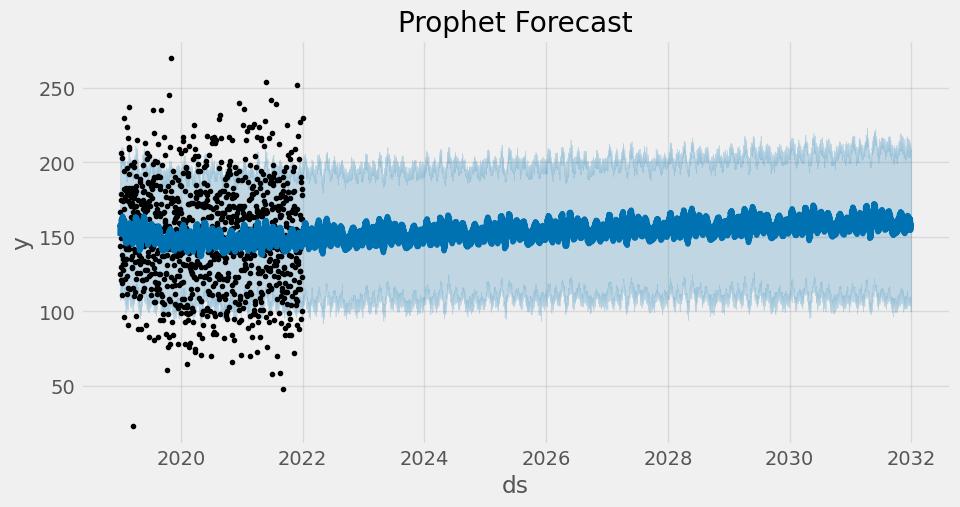

In [56]:
ts_prophet_cv_aid.predict_optimal_graph(10)